<a href="https://colab.research.google.com/github/sayid-alt/usd_idr_exchange_prediction/blob/main/usd_idr_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [4]:
# Run this code if you're using TPUv2-8 runtime
!pip install yfinance statsmodels tensorflow==2.16.*

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow
import tensorflow as tf
import urllib
import zipfile
import yfinance as yf
import os

from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from google.colab import files

In [6]:
print(tf.__version__)

2.16.2


# Utilities

In [7]:
# Plot series
def plot_series(df, columns, start_date=None, end_date=None, colors=['blue', 'red', 'green', 'yellow']):
  """Plots multiple series from a Pandas DataFrame with different colors.

  Args:
    df: Pandas DataFrame containing the time series data.
    columns: A list of column names to plot.
    colors: A list of colors to use for each series.
  """
  # Ensure the DataFrame index is a DatetimeIndex
  if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

  # plot start and end series time
  df = df.loc[start_date:end_date] if start_date and end_date else df

  fig, ax = plt.subplots(figsize=(15, 6))

  for i, column in enumerate(columns):
    ax.plot(df.index, df[column], color=colors[i % len(colors)], label=column)

  ax.set_xlabel("Time")
  ax.set_ylabel("Price")
  ax.legend()
  plt.show()


def plot_history(history):
  fig, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
  print(history.history.keys())

  params = history.history.keys()
  epochs = range(len(history.history['loss']))


  # Iterate over axes objects in the grid
   # Access and iterate over individual axes in the grid
  for i, param in enumerate(['loss', 'mae']):
    ax[i].set_title(param)
    ax[i].plot(epochs, history.history[param], label=param)
    ax[i].plot(epochs, history.history[f'val_{param}'], label=f'val_{param}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].grid(True)
    ax[i].legend()

  plt.show()

# Generate Data

## Extract data

---






This process of extracting data from yahoo finance using yfinance python library. The extacted dataset has been saved to the github account for fixed date range of dataset.
<br><br>
The Downloaded dataset then pushed into the github account for access it as public. <br> To access the dataset on github repository please visit this <a href="https://github.com/sayid-alt/usd_idr_exchange_prediction/tree/main/datasets">link<a/>.

In [8]:
idrx = yf.Ticker("IDR=X")
idrx.info

{'maxAge': 86400,
 'priceHint': 4,
 'previousClose': 15414.0,
 'open': 15480.0,
 'dayLow': 15480.0,
 'dayHigh': 15480.0,
 'regularMarketPreviousClose': 15414.0,
 'regularMarketOpen': 15480.0,
 'regularMarketDayLow': 15480.0,
 'regularMarketDayHigh': 15480.0,
 'bid': 15480.0,
 'ask': 15490.0,
 'fiftyTwoWeekLow': 14379.8,
 'fiftyTwoWeekHigh': 16510.2,
 'fiftyDayAverage': 15583.678,
 'twoHundredDayAverage': 15858.69,
 'currency': 'IDR',
 'exchange': 'CCY',
 'quoteType': 'CURRENCY',
 'symbol': 'IDR=X',
 'underlyingSymbol': 'IDR=X',
 'shortName': 'USD/IDR',
 'longName': 'USD/IDR',
 'firstTradeDateEpochUtc': 993682800,
 'timeZoneFullName': 'Europe/London',
 'timeZoneShortName': 'BST',
 'uuid': 'af5a8623-ae2e-3352-96c8-72c36440574c',
 'messageBoardId': 'finmb_IDR_X',
 'gmtOffSetMilliseconds': 3600000,
 'trailingPegRatio': None}

In [9]:
idrx_history = idrx.history(period="max") # period 5 years from the running code, it might changes overtime
idrx_history.sort_values(by='Date', ascending=True, inplace=True)
idrx_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-06-28 00:00:00+01:00,11441.000000,11565.000000,11338.000000,11448.000000,0,0.0,0.0
2001-06-29 00:00:00+01:00,11370.000000,11510.000000,11265.000000,11390.000000,0,0.0,0.0
2001-07-02 00:00:00+01:00,11315.000000,11490.000000,11215.000000,11320.000000,0,0.0,0.0
2001-07-03 00:00:00+01:00,11330.000000,11455.000000,11188.000000,11322.000000,0,0.0,0.0
2001-07-04 00:00:00+01:00,11355.000000,11465.000000,11251.000000,11365.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-01 00:00:00+01:00,15170.599609,15250.099609,15148.799805,15170.599609,0,0.0,0.0
2024-10-02 00:00:00+01:00,15260.599609,15289.900391,15187.200195,15260.599609,0,0.0,0.0
2024-10-03 00:00:00+01:00,15324.000000,15507.900391,15294.000000,15324.000000,0,0.0,0.0


In [10]:
idrx_history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5866 entries, 2001-06-28 00:00:00+01:00 to 2024-10-05 00:00:00+01:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5866 non-null   float64
 1   High          5866 non-null   float64
 2   Low           5866 non-null   float64
 3   Close         5866 non-null   float64
 4   Volume        5866 non-null   int64  
 5   Dividends     5866 non-null   float64
 6   Stock Splits  5866 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 366.6 KB


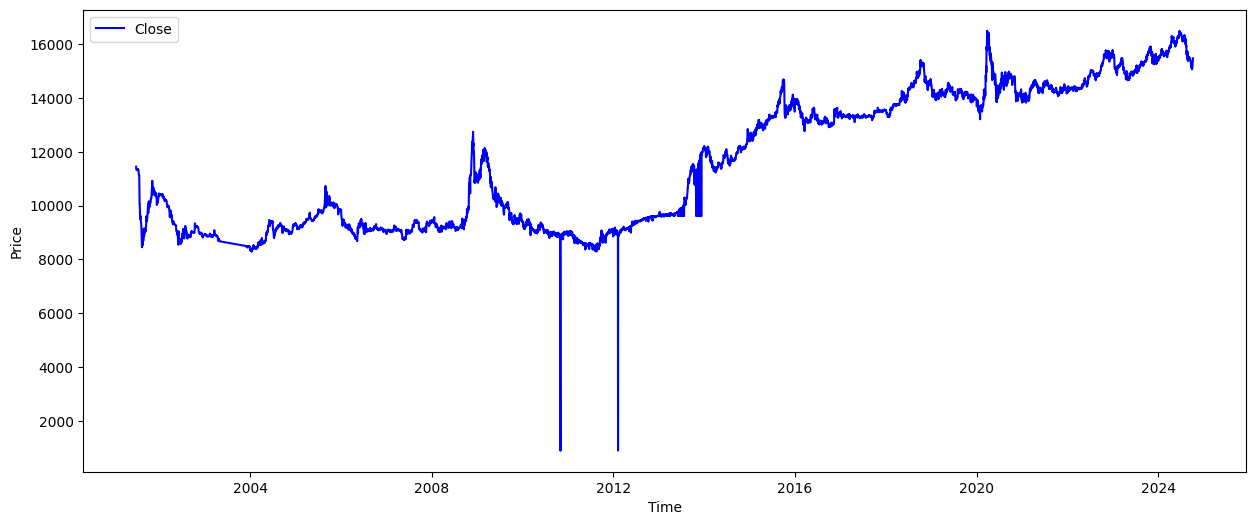

In [11]:
plot_series(idrx_history, columns=['Close'])

## Looking for 2002-2024 dataset range

In [12]:
idrx_2002_2024 = idrx_history.loc['2002-01-01':'2024-01-01']
idrx_2002_2024

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-01-02 00:00:00+00:00,10435.000000,10575.0,10295.000000,10415.000000,0,0.0,0.0
2002-01-03 00:00:00+00:00,10358.000000,10500.0,10258.000000,10375.000000,0,0.0,0.0
2002-01-04 00:00:00+00:00,10428.000000,10600.0,10195.000000,10428.000000,0,0.0,0.0
2002-01-07 00:00:00+00:00,10390.000000,10528.0,10290.000000,10390.000000,0,0.0,0.0
2002-01-08 00:00:00+00:00,10423.000000,10523.0,10323.000000,10423.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-26 00:00:00+00:00,15460.000000,15460.0,15398.500000,15460.000000,0,0.0,0.0
2023-12-27 00:00:00+00:00,15400.000000,15434.0,15347.400391,15400.000000,0,0.0,0.0
2023-12-28 00:00:00+00:00,15373.000000,15443.0,15369.200195,15373.000000,0,0.0,0.0


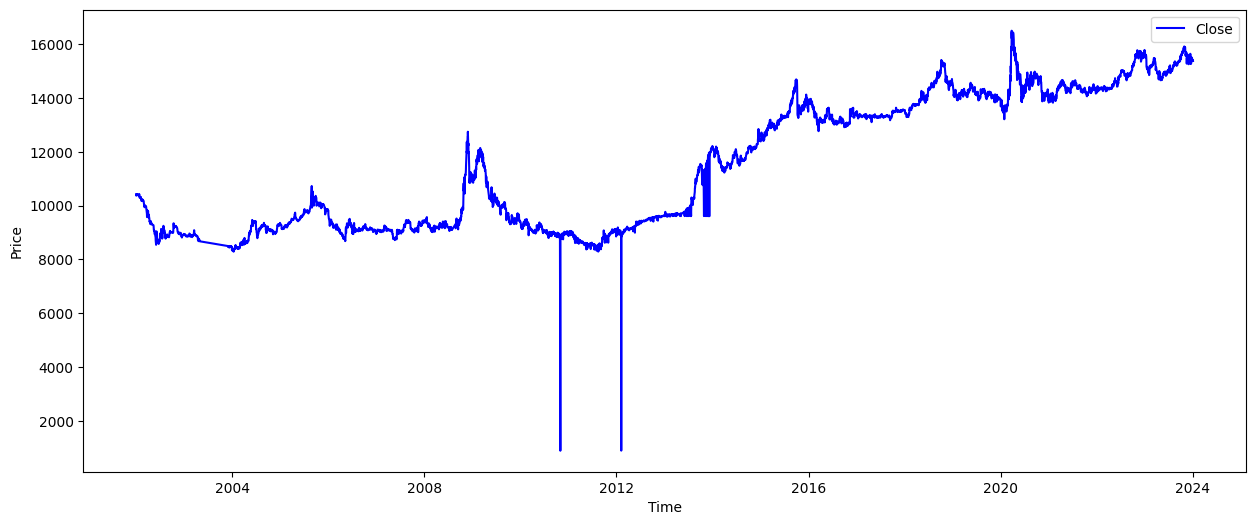

In [13]:
plot_series(idrx_2002_2024, columns=['Close'])

## Save loaded dataset to csv file

In [14]:
# save csv file
def save_csv(df, dir, download=False):
  '''
    All downloaded file will stored in download directory
  '''
  os.makedirs('download', exist_ok=True)
  print(f'Success make dir download')
  save_path = os.path.join('download', dir)
  df.to_csv(save_path)
  print(f'Success save {save_path} to /download{save_path}')

  if download:
    files.download(save_path)

# # Uncomment code below for downloading the file
# save_path = "usd_idr_historical_data_20y.csv"
# # set download to False if you just want to save csv
# save_csv(idrx_history, save_path, download=False)

## Load Dataset

In [15]:
idrx_df = idrx_2002_2024
idrx_df.sort_values(by='Date', ascending=False, inplace=True)

<ipython-input-15-4e13b082f74a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idrx_df.sort_values(by='Date', ascending=False, inplace=True)


In [16]:
idrx_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-01 00:00:00+00:00,15383.099609,15383.0,15383.000000,15383.099609,0,0.0,0.0
2023-12-29 00:00:00+00:00,15425.000000,15536.5,14416.500000,15425.000000,0,0.0,0.0
2023-12-28 00:00:00+00:00,15373.000000,15443.0,15369.200195,15373.000000,0,0.0,0.0
2023-12-27 00:00:00+00:00,15400.000000,15434.0,15347.400391,15400.000000,0,0.0,0.0
2023-12-26 00:00:00+00:00,15460.000000,15460.0,15398.500000,15460.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2002-01-08 00:00:00+00:00,10423.000000,10523.0,10323.000000,10423.000000,0,0.0,0.0
2002-01-07 00:00:00+00:00,10390.000000,10528.0,10290.000000,10390.000000,0,0.0,0.0
2002-01-04 00:00:00+00:00,10428.000000,10600.0,10195.000000,10428.000000,0,0.0,0.0


In [17]:
idrx_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5542 entries, 2024-01-01 00:00:00+00:00 to 2002-01-02 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5542 non-null   float64
 1   High          5542 non-null   float64
 2   Low           5542 non-null   float64
 3   Close         5542 non-null   float64
 4   Volume        5542 non-null   int64  
 5   Dividends     5542 non-null   float64
 6   Stock Splits  5542 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 346.4 KB


In [18]:
for col in idrx_df.columns:
  print(f'{col}: {idrx_df[col].unique().sum()}')

Open: 50322452.58068848
High: 51687615.17578125
Low: 48543143.94091797
Close: 50017249.86291504
Volume: 0
Dividends: 0.0
Stock Splits: 0.0


`Volume`, `Dividends`, `Stock Splits` does not give much information, so we'll drop it

In [19]:
idrx_df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
idrx_df

<ipython-input-19-50d57ddecc62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idrx_df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)


,Open,High,Low,Close
Date,,,,
2024-01-01 00:00:00+00:00,15383.099609,15383.0,15383.000000,15383.099609
2023-12-29 00:00:00+00:00,15425.000000,15536.5,14416.500000,15425.000000
2023-12-28 00:00:00+00:00,15373.000000,15443.0,15369.200195,15373.000000
2023-12-27 00:00:00+00:00,15400.000000,15434.0,15347.400391,15400.000000
2023-12-26 00:00:00+00:00,15460.000000,15460.0,15398.500000,15460.000000
...,...,...,...,...
2002-01-08 00:00:00+00:00,10423.000000,10523.0,10323.000000,10423.000000
2002-01-07 00:00:00+00:00,10390.000000,10528.0,10290.000000,10390.000000
2002-01-04 00:00:00+00:00,10428.000000,10600.0,10195.000000,10428.000000


Much better! :)

Now we'll look into the moving data point in each columns

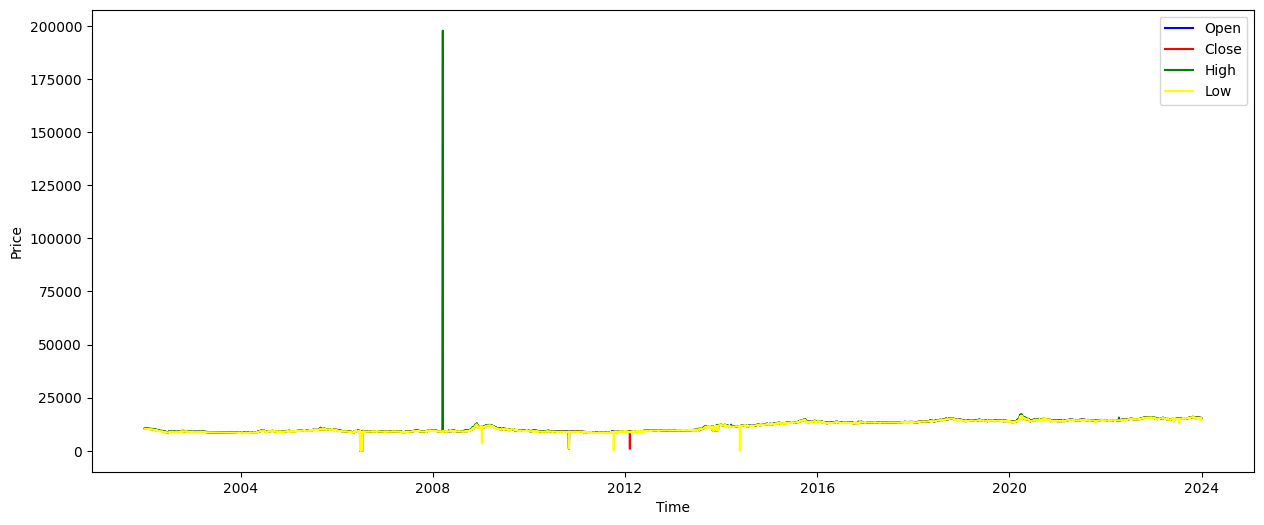

In [20]:
plot_series(idrx_df, ['Open', 'Close', 'High', 'Low'])

Looks there is outlier in value, and we should handle it later

# Preprocessing

## Check for missing value

In [21]:
idrx_df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0


## Check stationary (unit root test)
To determine whether a time series has a unit root (and is thus non-stationary), we typically use tests like the Augmented Dickey-Fuller (ADF) test

In [22]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(df, columns):

  for num, column in enumerate(columns):

    # Just print the line if checking more than one columns
    if len(columns) > 1 & num > 0:
      print('\n'.ljust(50, '-'))

    # Title for columns that checked
    print(f'{num+1}). ADF For column {column}:')

    # results that contained from adfuller
    results = adfuller(df[column])

    print(f'ADF_statistic: {results[0]}')
    print(f'p-value: {results[1]}')
    print(f'Number of lags used: {results[2]}')

    print(f'Critical Values:')
    for key, value in results[4].items():
      print(f'{key}: {value}')

    if results[1] <= 0.05: # p-value <= 0.05
      print(f"\n\033[32mThe series is stationary!\033[0m")
    else:
      print(f'\n\033[31mThe series is not stationary!\033[0m')



In [23]:
check_stationary(df=idrx_df, columns=idrx_df.columns)

1). ADF For column Open:
ADF_statistic: -1.806888000429431
p-value: 0.3770473946763033
Number of lags used: 33
Critical Values:
1%: -3.4315377905202316
5%: -2.8620648856245223
10%: -2.5670493954222

The series is not stationary!

-------------------------------------------------
2). ADF For column High:
ADF_statistic: -2.7087063850509976
p-value: 0.07254376349047117
Number of lags used: 33
Critical Values:
1%: -3.4315377905202316
5%: -2.8620648856245223
10%: -2.5670493954222

The series is not stationary!
3). ADF For column Low:
ADF_statistic: -1.8494265285718154
p-value: 0.35621330235495363
Number of lags used: 33
Critical Values:
1%: -3.4315377905202316
5%: -2.8620648856245223
10%: -2.5670493954222

The series is not stationary!

-------------------------------------------------
4). ADF For column Close:
ADF_statistic: -1.700201117978725
p-value: 0.43100885781500853
Number of lags used: 16
Critical Values:
1%: -3.4315341340800396
5%: -2.8620632701622672
10%: -2.567048535459962

The s

Looks that the series has a unit root (non-stationary), here's now we need to difference the time series

In [24]:
idrx_diff = idrx_df.diff(periods=1)
idrx_diff.dropna(inplace=True)
idrx_diff = pd.DataFrame(idrx_diff)
idrx_diff

,Open,High,Low,Close
Date,,,,
2023-12-29 00:00:00+00:00,41.900391,153.5,-966.500000,41.900391
2023-12-28 00:00:00+00:00,-52.000000,-93.5,952.700195,-52.000000
2023-12-27 00:00:00+00:00,27.000000,-9.0,-21.799805,27.000000
2023-12-26 00:00:00+00:00,60.000000,26.0,51.099609,60.000000
2023-12-25 00:00:00+00:00,-50.799805,0.0,61.500000,-50.799805
...,...,...,...,...
2002-01-08 00:00:00+00:00,-10.000000,-15.0,3.000000,3.000000
2002-01-07 00:00:00+00:00,-33.000000,5.0,-33.000000,-33.000000
2002-01-04 00:00:00+00:00,38.000000,72.0,-95.000000,38.000000


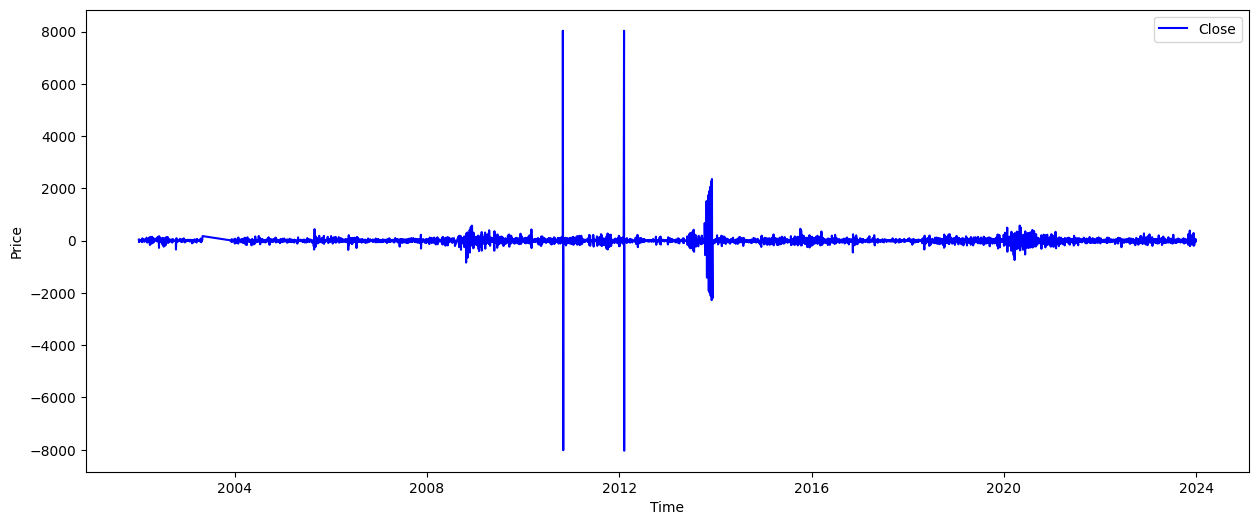

In [25]:
plot_series(idrx_diff, ['Close'])

Looks the data has removed the unit root, now we'll check the stationary using ADF again

In [26]:
check_stationary(idrx_diff, columns=idrx_diff.columns)

1). ADF For column Open:
ADF_statistic: -18.881543187280055
p-value: 0.0
Number of lags used: 33
Critical Values:
1%: -3.431538006308296
5%: -2.8620649809623995
10%: -2.567049446173612

The series is stationary!

-------------------------------------------------
2). ADF For column High:
ADF_statistic: -21.333188676602955
p-value: 0.0
Number of lags used: 33
Critical Values:
1%: -3.431538006308296
5%: -2.8620649809623995
10%: -2.567049446173612

The series is stationary!
3). ADF For column Low:
ADF_statistic: -18.465972730618905
p-value: 2.1433211440123122e-30
Number of lags used: 33
Critical Values:
1%: -3.431538006308296
5%: -2.8620649809623995
10%: -2.567049446173612

The series is stationary!

-------------------------------------------------
4). ADF For column Close:
ADF_statistic: -20.240752714029682
p-value: 0.0
Number of lags used: 15
Critical Values:
1%: -3.4315341340800396
5%: -2.8620632701622672
10%: -2.567048535459962

The series is stationary!


## Checking ACF and PACF

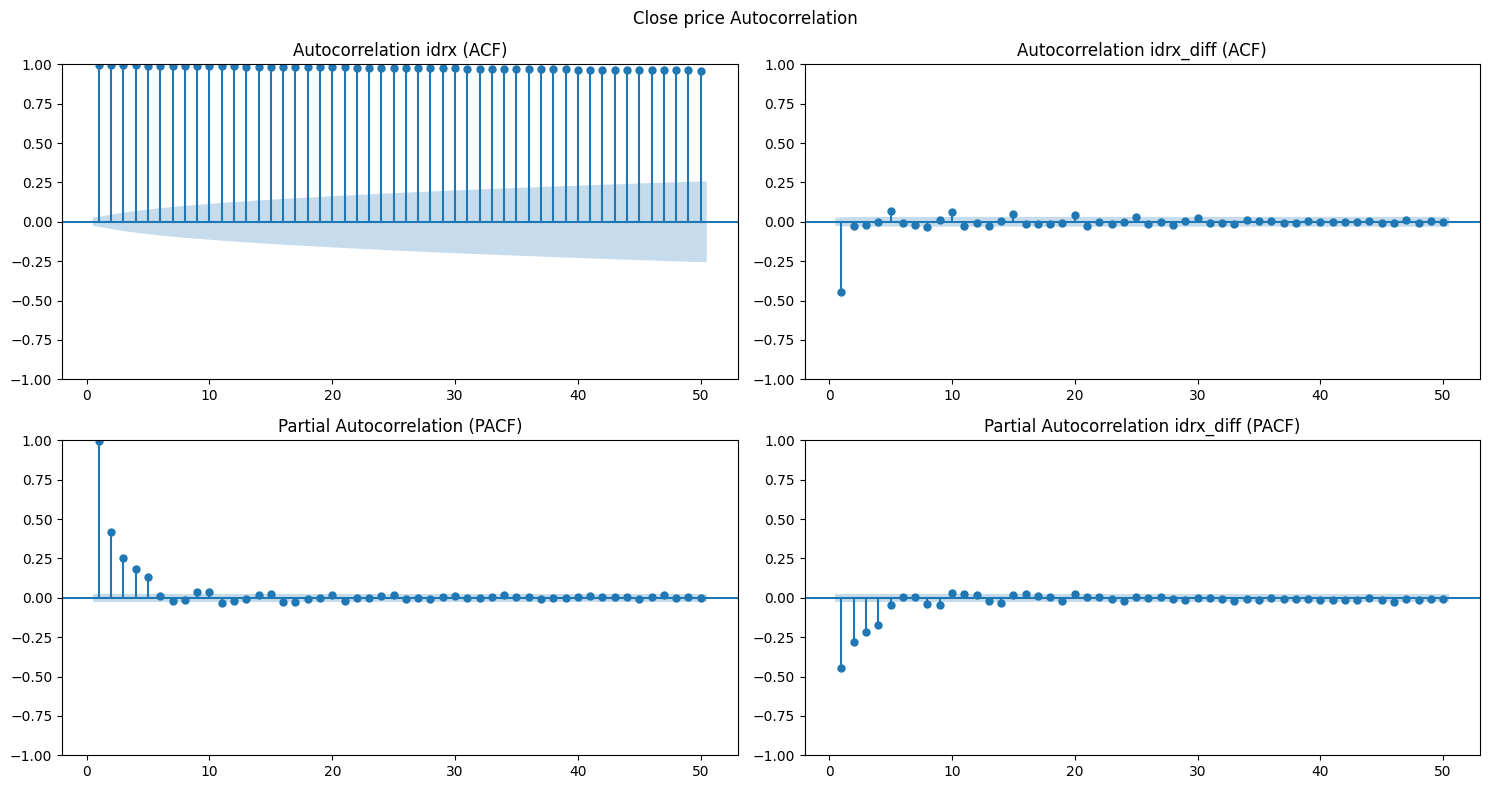

In [27]:
fig, ax = plt.subplots(figsize=(15, 8), ncols=2, nrows=2)
# Plot the ACF
fig.suptitle('Close price Autocorrelation')
plot_acf(idrx_df['Close'], lags=50, title="Autocorrelation idrx (ACF)", zero=False, ax=ax[0][0])
plot_acf(idrx_diff['Close'], lags=50, title="Autocorrelation idrx_diff (ACF)", zero=False, ax=ax[0][1])


# Plot the PACF
plot_pacf(idrx_df['Close'], lags=50, title="Partial Autocorrelation (PACF)", zero=False, ax=ax[1][0])
plot_pacf(idrx_diff['Close'], lags=50, title="Partial Autocorrelation idrx_diff (PACF)", zero=False, ax=ax[1][1])

plt.tight_layout()
plt.show()

**ACF Plot**: If there are significant spikes at certain lags, it indicates that the time series at those lags is correlated with the current values, which may help in deciding the window size. <br>
<br>
**PACF Plot**: Helps determine the number of autoregressive terms. If PACF drops sharply after a few lags, it means that those lags are the most significant for predicting future values.

## Split data

Here we're going to split the dataset into train and valid dataset. Where each will be differenced dataset (stationary) and original dataset (non-stationary), which both would be trained and compared their accuracy to receive a better model

In [28]:
split_time = int(len(idrx_df) * 0.2)
train_series = idrx_df[:-split_time]
valid_series = idrx_df[-split_time:]
train_series_diff = idrx_diff[:-split_time]
valid_series_diff = idrx_diff[-split_time:]

### train test series

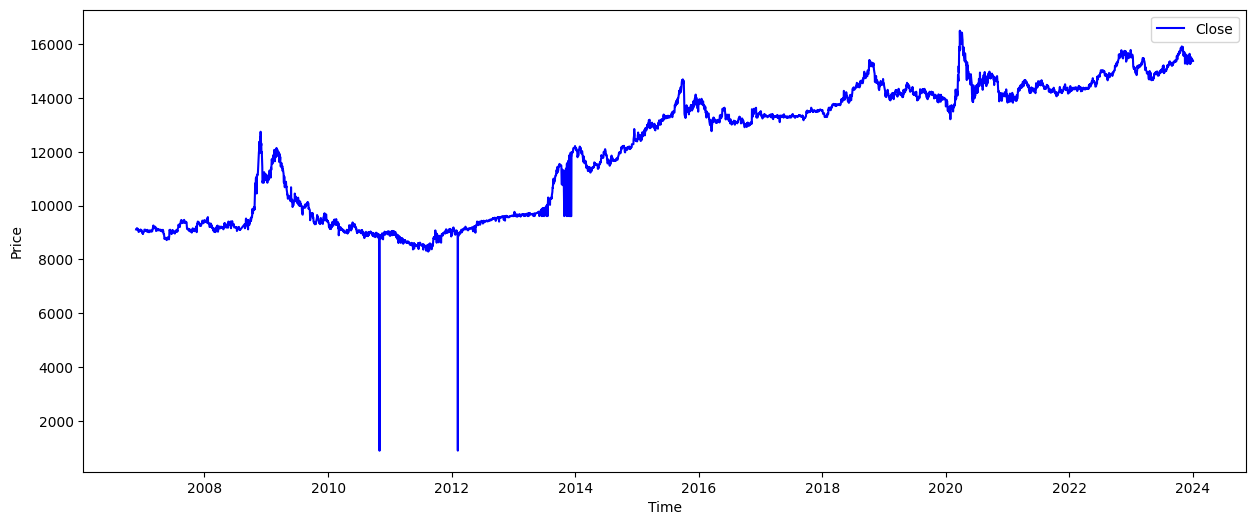

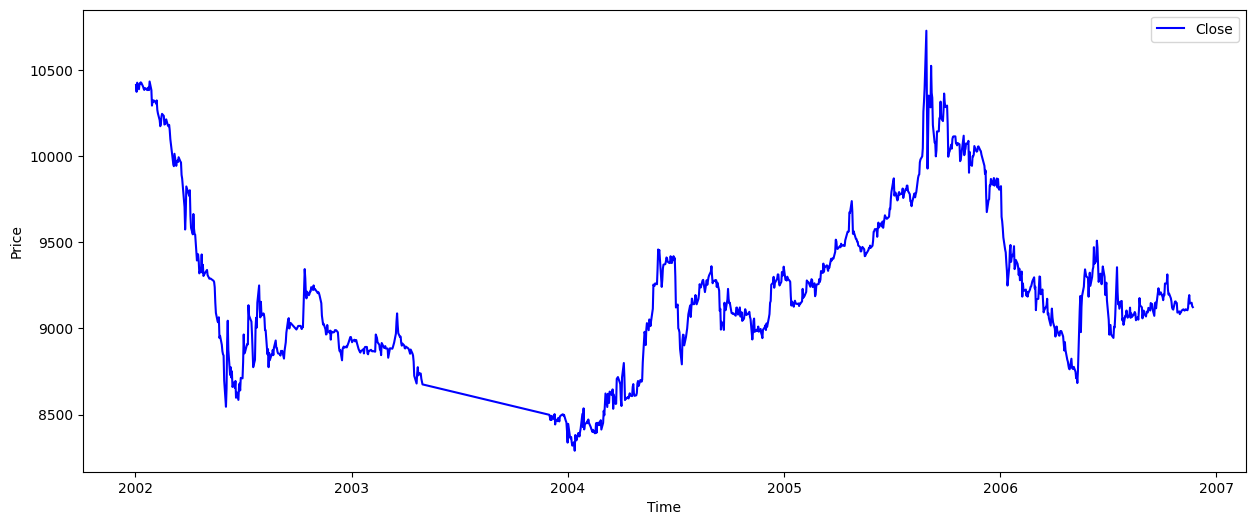

In [29]:
# plot train series
plot_series(train_series, ['Close'])
# plot validation series
plot_series(valid_series, ['Close'])

### train test series diff

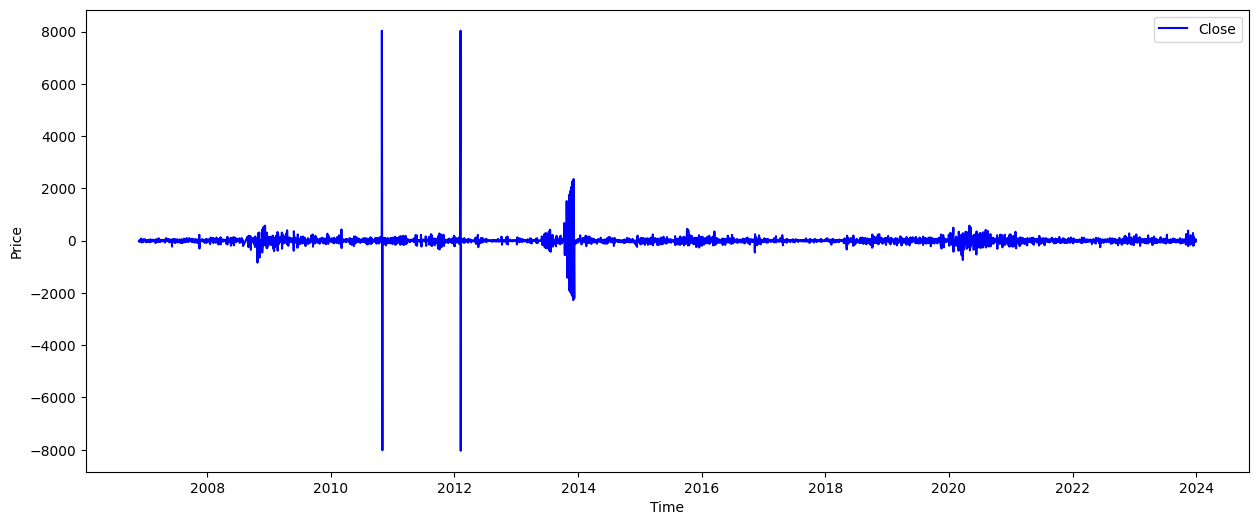

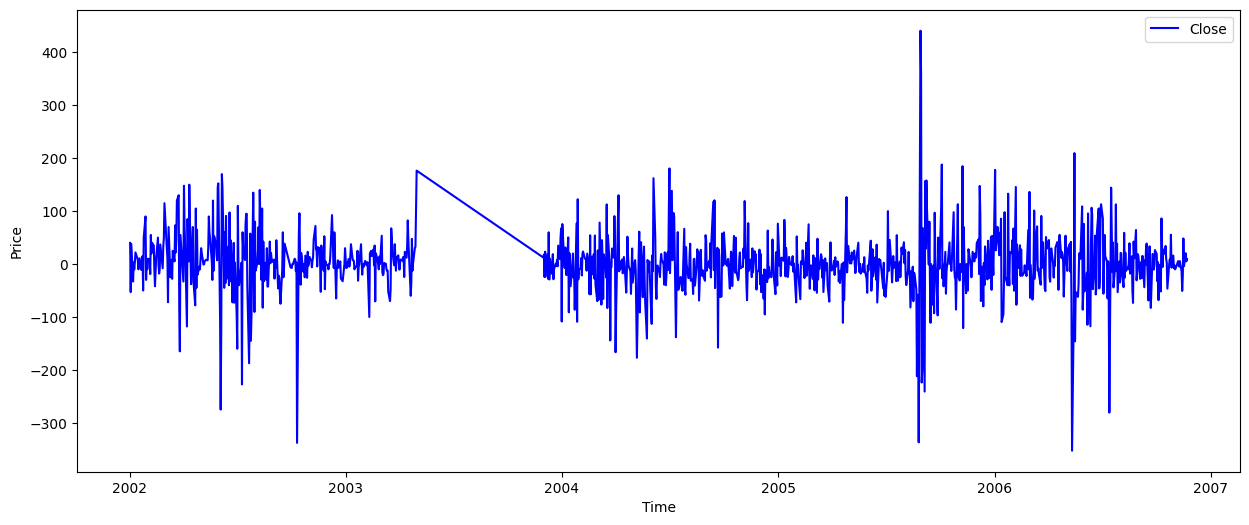

In [30]:
plot_series(train_series_diff, ['Close'])
plot_series(valid_series_diff, ['Close'])

# Windowing Data Series
•	For a Differenced Series (idrx_diff): Start with a window size of 1 or 2, since most of the correlation is explained within those lags.

•	For the Original Series (idrx): If you’re not differencing the series, you might consider a larger window size to account for the strong autocorrelation seen in the ACF (e.g., a window size between 10 to 20).

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # create tf dataset
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # windowed dataset as window size
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

  # flat the window
  dataset = dataset.flat_map(lambda window : window.batch(window_size+1))

  # map the window to input and target value
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # shuffle the dataset
  dataest = dataset.shuffle(shuffle_buffer)

  # batching the dataset and prefetch 1 data point
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [32]:
BATCH_SIZE = 60
WINDOW_SIZE = 60 # will be explore more and fine tuned the value
WINDOW_SIZE_DIFF = 30 # will be explore more and fine tuned the value
SHUFFLE_BUFFER = len(train_series)

train_idrx = windowed_dataset(train_series['Close'], window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER)
valid_idrx = windowed_dataset(valid_series['Close'], window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER)

In [33]:
for j, data in enumerate(train_idrx.take(2)):
  # Look up the 5 first training datasetes from batch 1 and 2
  print(f'\n\033[1mBATCH: {j}\033[0m '.ljust(50, '-'))
  for i in range(5):
    print(f'\033[32mseries\033[0m: {data[0][i].numpy()}\n\033[31mtarget\033[0m: {data[1][i].numpy()}')


BATCH: 0 --------------------------------
series: [15383.09960938 15425.         15373.         15400.
 15460.         15409.20019531 15440.         15518.
 15455.         15454.40039062 15282.79980469 15468.
 15275.         15569.         15647.         15560.20019531
 15500.         15480.         15457.         15519.90039062
 15437.40039062 15549.29980469 15407.         15259.
 15466.5        15560.         15495.         15612.79980469
 15501.29980469 15382.09960938 15399.40039062 15475.
 15487.79980469 15281.         15667.         15683.
 15713.70019531 15616.         15643.59960938 15570.
 15582.09960938 15838.         15900.         15748.70019531
 15843.         15903.5        15920.         15877.5
 15868.         15874.         15868.         15856.
 15807.         15728.20019531 15675.         15676.
 15739.         15693.         15718.5        15691.40039062]
target: 15603.0
series: [15425.         15373.         15400.         15460.
 15409.20019531 15440.         1551

In [34]:
for j, data in enumerate(train_idrx_diff.take(2)):
  # Look up the 5 first training datasetes from batch 1 and 2
  print(f'\n\033[1mBATCH: {j}\033[0m '.ljust(50, '-'))
  for i in range(5):
    print(f'\033[32mseries\033[0m: {data[0][i].numpy()}\n\033[31mtarget\033[0m: {data[1][i].numpy()}')


BATCH: 0 --------------------------------
series: [  41.90039062  -52.           27.           60.          -50.79980469
   30.79980469   78.          -63.           -0.59960938 -171.60058594
  185.20019531 -193.          294.           78.          -86.79980469
  -60.20019531  -20.          -23.           62.90039062  -82.5
  111.89941406 -142.29980469 -148.          207.5          93.5
  -65.          117.79980469 -111.5        -119.20019531   17.30078125]
target: 75.599609375
series: [ -52.           27.           60.          -50.79980469   30.79980469
   78.          -63.           -0.59960938 -171.60058594  185.20019531
 -193.          294.           78.          -86.79980469  -60.20019531
  -20.          -23.           62.90039062  -82.5         111.89941406
 -142.29980469 -148.          207.5          93.5         -65.
  117.79980469 -111.5        -119.20019531   17.30078125   75.59960938]
target: 12.7998046875
series: [  27.           60.          -50.79980469   30.79980469  

# Build the model

In [42]:
# set methods for compiler
loss = tf.keras.losses.Huber(),
optimizer = tf.keras.optimizers.SGD(momentum=0.9),
metrics = [MeanSquaredError(),
           MeanAbsolutePercentageError(), MeanAbsoluteError(), RootMeanSquaredError()]

def build_model(window_size):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(window_size, 1)))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)))
  model.add(tf.keras.layers.LSTM(60, return_sequences=True))
  model.add(tf.keras.layers.Conv1D(filters=60,
                                   kernel_size=5,
                                   activation='relu',
                                   strides=1,
                                   padding='valid'))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dense(30, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  model.add(tf.keras.layers.Lambda(lambda x: x * 10000))

  return model

## Tune the learning Rate (This section just for tuning a learning rate, be careful to run code below)

In [34]:
model_tune = build_model(window_size=WINDOW_SIZE)

model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 60, 120)           29760     
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            43440     
                                                                 
 conv1d (Conv1D)             (None, 56, 60)            18060     
                                                                 
 max_pooling1d (MaxPooling1  (None, 28, 60)            0         
 D)                                                              
                                                                 
 global_average_pooling1d (  (None, 60)                0         
 GlobalAveragePooling1D)                                         
                                                        

In [33]:
# Get initial weights
init_weights = model_tune.get_weights()

In [34]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10**(epoch/20)
    , verbose=1)

model_tune.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)


In [35]:
history = model_tune.fit(train_idrx, epochs=100,
                    callbacks=[lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 1e-08.
Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - loss: 10089.3623 - mean_absolute_error: 10089.8633 - mean_absolute_percentage_error: 70.5733 - mean_squared_error: 114880376.0000 - root_mean_squared_error: 10582.4521 - learning_rate: 1.0000e-08

Epoch 2: LearningRateScheduler setting learning rate to 1.1220184543019634e-08.
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 3032.7168 - mean_absolute_error: 3033.2168 - mean_absolute_percentage_error: 21.4856 - mean_squared_error: 12259135.0000 - root_mean_squared_error: 3385.1274 - learning_rate: 1.1220e-08

Epoch 3: LearningRateScheduler setting learning rate to 1.2589254117941673e-08.
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - loss: 3166.8455 - mean_absolute_error: 3167.3455 - mean_absolute_percentage_error: 22.3357 - mean_squared_error: 13945214.0000 - root_mean_squared_error: 3574.1638 - learning_rate: 1.2589e-08

Epoch 4: LearningRateScheduler setting learning rate to 1.4125375446227544e-08.
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - loss: 3030.1838 - mean_absolute_error: 3030.6838 - mean_absolute_percentage_error: 21.3608 - mean_squared_error: 12965234.0000 - root_mean_squared_error: 3441.0146 - learning_rate: 1.4125e-08

Epoch 5: LearningRateScheduler setting learning rate to 1.5848931924611136e-08.
Epoch 5/100
73/73 ━━━━━━━

In [37]:

lrs = 1e-8 * (10 ** (np.arange(100)/20))

def plot_learning_rates(lrs, history, axis=None):
  fig, ax = plt.subplots(figsize=(15, 5))
  # Set the grid
  plt.grid(True)

  plt.semilogx(lrs, history.history['loss'])
  # Increase the tickmarks size
  plt.tick_params('both', length=10, width=1, which='both')
  # Set the plot boundaries
  plt.axis(axis)

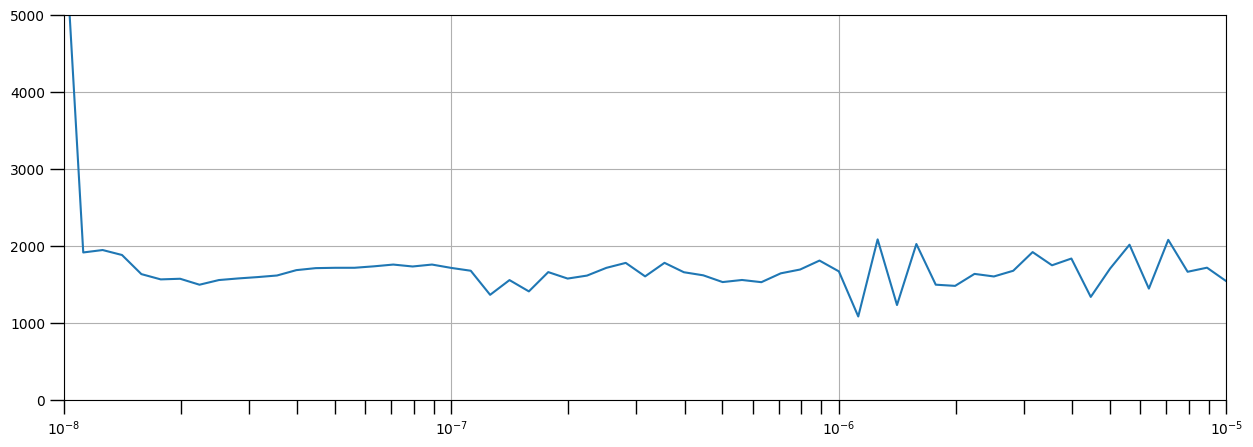

In [40]:
plot_learning_rates(lrs, history, axis=[1e-8, 1e-5, 0, 5000])

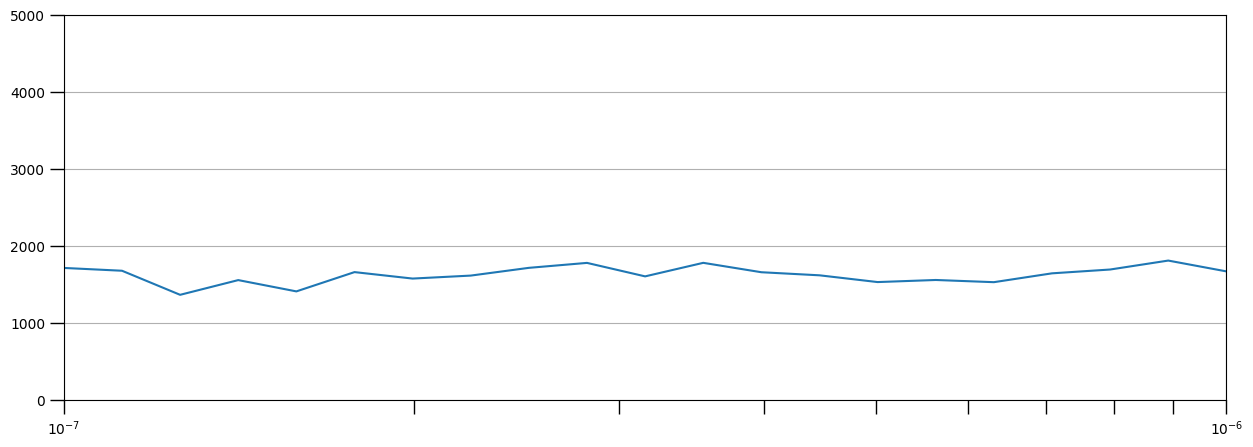

In [41]:
plot_learning_rates(lrs, history, axis=[1e-7, 1e-6, 0, 5000])

In [42]:
# clear the backend
tf.keras.backend.clear_session()

# reset the weights
model_tune.set_weights(init_weights)

## End of Learning Rate tuning (be careful to run the code above)

# Train the model

In [43]:
model = build_model(window_size=WINDOW_SIZE)

# set the learning rate
learning_rate = 6e-7

model.compile(loss=loss,
              optimizer=tf.keras.optimizers.SGD(
                  momentum=0.9, learning_rate=learning_rate),
              metrics=metrics)

In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 60, 120)             │          29,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 60, 60)              │          43,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 56, 60)              │          18,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 28, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 60)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,411 (364.89 KB)

 Trainable params: 93,411 (364.89 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = model.fit(train_idrx,
                    epochs=250,
                    validation_data=valid_idrx,
                    batch_size=BATCH_SIZE)

Epoch 1/250
     73/Unknown 8s 67ms/step - loss: 5701.8828 - mean_absolute_error: 5702.3828 - mean_absolute_percentage_error: 38.8647 - mean_squared_error: 68106368.0000 - root_mean_squared_error: 7621.8989

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 5659.4043 - mean_absolute_error: 5659.9043 - mean_absolute_percentage_error: 38.6071 - mean_squared_error: 67480232.0000 - root_mean_squared_error: 7581.9551 - val_loss: 1011.6156 - val_mean_absolute_error: 1012.1156 - val_mean_absolute_percentage_error: 10.7158 - val_mean_squared_error: 1259797.2500 - val_root_mean_squared_error: 1122.4069
Epoch 2/250
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 3779.4033 - mean_absolute_error: 3779.9033 - mean_absolute_percentage_error: 25.9706 - mean_squared_error: 23661008.0000 - root_mean_squared_error: 4622.5073 - val_loss: 494.4033 - val_mean_absolute_error: 494.9033 - val_mean_absolute_percentage_error: 5.4496 - val_mean_squared_error: 324676.8125 - val_root_mean_squared_error: 569.8042
Epoch 3/250
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 2843.1394 - mean_absolute_error: 2843.6392 - mean_absolute_percentage_error: 19.6275 - mean_squared_error: 13945739.0000 - root_mean_squared_error: 353

In [143]:
def plot_history(history):
  params = [keys for keys in history.history.keys()]
  print(params)
  epochs = range(len(history.history['loss']))

  ncols = 2
  nrows= len(params)//ncols//2 +1
  fig, axs = plt.subplots(figsize=(16, 5*nrows), ncols=ncols, nrows=nrows)
  axs = axs.flatten()

  # Iterate over axses objects in the grid
   # Access and iterate over individual axses in the grid
  for i, param in enumerate(list(params)):
    if 'val' not in param:
      axs[i].set_title(param)
      axs[i].plot(epochs, history.history[f'val_{param}'], label=f'val_{param}')
      axs[i].set_title(param)
      axs[i].plot(epochs, history.history[param], label=param)

      axs[i].set_xlabel('Epochs')
      axs[i].set_ylabel('Loss')
      axs[i].grid(True)
      axs[i].legend()

  plt.show()

['loss', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_mean_squared_error', 'val_root_mean_squared_error']


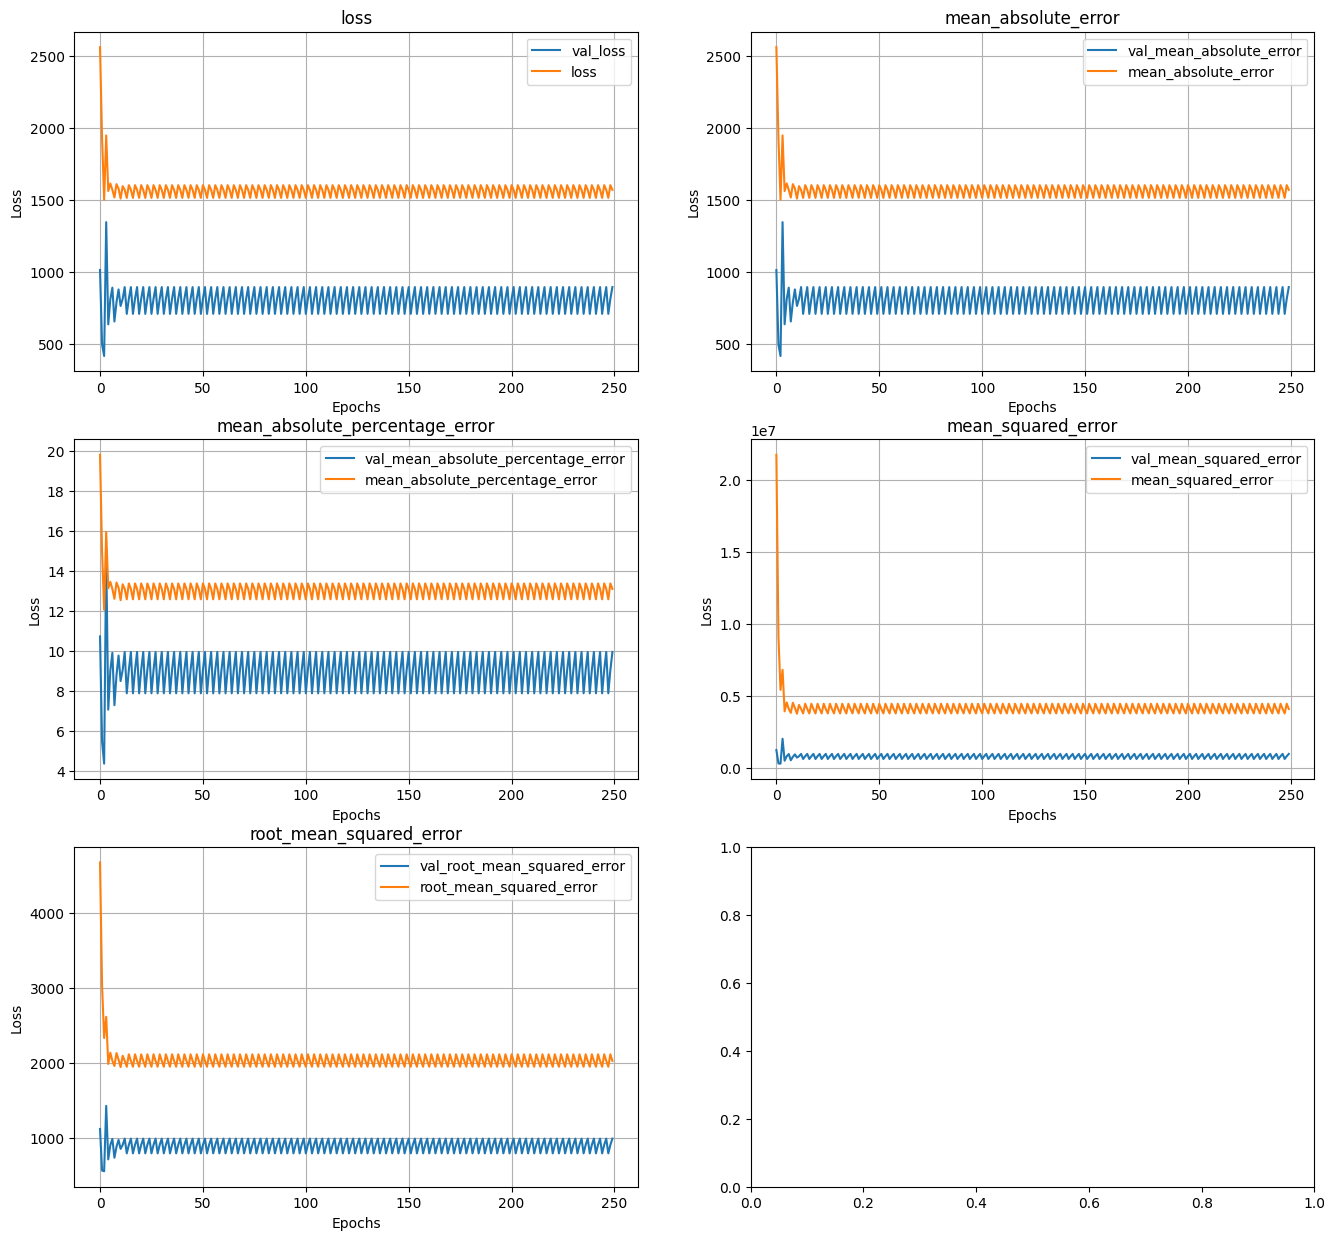

In [144]:
plot_history(history)

In [145]:
history_data = history.history
history_df = pd.DataFrame(history_data, columns=history_data.keys())
history_df['average'] = history_df.mean(axis=1)
history_df.sort_values(by='average', ascending=True)

,loss,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,root_mean_squared_error,val_loss,val_mean_absolute_error,val_mean_absolute_percentage_error,val_mean_squared_error,val_root_mean_squared_error,average
7,1514.826660,1515.326538,12.599509,3840207.25,1959.644653,654.396851,654.896851,7.274613,5.479068e+05,740.207214,4.395173e+05
13,1512.051880,1512.551880,12.574962,3801220.25,1949.671875,707.218384,707.718140,7.868858,6.363967e+05,797.744751,4.444824e+05
16,1512.052002,1512.552002,12.574960,3801219.25,1949.671631,707.219788,707.719604,7.868874,6.363992e+05,797.746338,4.444826e+05
19,1512.052002,1512.552002,12.574966,3801217.75,1949.671143,707.222046,707.721802,7.868899,6.364030e+05,797.748718,4.444828e+05
22,1512.052246,1512.552246,12.574965,3801216.25,1949.670776,707.223511,707.723267,7.868914,6.364054e+05,797.750244,4.444829e+05
...,...,...,...,...,...,...,...,...,...,...,...
5,1612.218628,1612.718506,13.446550,4565348.50,2136.667725,808.348022,808.847900,8.999434,8.229312e+05,907.155579,5.396188e+05
2,1500.088989,1500.588989,12.055293,5437094.50,2331.757812,414.926422,415.425934,4.350311,3.134195e+05,559.838867,5.757253e+05
3,1945.947144,1946.447144,15.948792,6833725.00,2614.139404,1343.952759,1344.452759,14.861767,2.042408e+06,1429.128418,8.886788e+05
1,1922.738403,1923.238281,14.947407,9137316.00,3022.799316,494.403259,494.903259,5.449574,3.246768e+05,569.804199,9.470441e+05
